Das Projekt hat sich die Erstellung eines Passwort-Generators als Ziel gesetzt. Dabei sollen die zu erstellenden Passwörter möglichst denen eines Menschen ähneln. 
Zur Realisierung wurde die RNN- Architektur verwendet. Diese Recurrent Neural Networks ermöglichen es, Voraussagen mittels eines Kontext zu treffen, der durch frühere Inputs entstanden ist. Das Netzwerk verfügt sozusagen über ein Gedächtnis. In der Umsetzung geschieht dies durch die Kombination des Hidden-Layern aus der vorherigen Sequenz mit den Hidden-Layern aus der aktuellen Sequenz. Die vorherigen Hidden-Layer haben damit Einfluß auf den Output der nächsten Sequenz. Dieser Algorithmus wird in einer Schleife abgebildet, bis sämtliche Inputs verarbeitet wurden und der Kontext ersichtlich ist.
Klarer wird dies mit den nachfolgenden Formeln, mit denen das Netzwerk trainiert wird:

\begin{align}
\ h_t  = f(W^{hh}h_t-1 + W^{hx} + x_t \\
\ y_t  = softmax(W^Sh_t) \\
\ J^t(\theta)  =\sum_{i=1}^{[V]} (y_{ti}\log(y_{ti}))
\end{align}

Die erste Formel ist dafür da, sich an die Hidden-Layer des vorherigen Durchlaufs zu "erinnern". Dabei wird durch h-1 auf den vorherigen Hidden-Layer zugegriffen. Dies wird kombiniert mit dem aktuellen x, auch wird anschließend eine Akivierungsfunktion durchgeführt, am gebräuchlisten sind hierbei der Tangens hyperbolicus oder die Sigmoid-Funktion.
Die zweite Formel kümmert sich um die Voraussage des nächsten Ergebnisses in Form von einer Wahrscheinlichkeitsverteilung. 
Zum Schluss wird in der dritten Formel mittels der Cross-Entropy-Loss-Funktion der Fehler zwischen dem Input und dem Output berechnet.

In [1]:
#Imports
from __future__ import unicode_literals, print_function, division
from io import open
import wget # to download passwordlist
import glob
import os
import random
import numpy as np
import unicodedata
import string
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

Auslesen der Passworddatei:

In [2]:
# https://stackoverflow.com/a/518232/2809427
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in letters
    )

def readPasswords(filename):
    passwords = []
    with open(filename, 'r', encoding="utf8", errors='ignore') as f:
        for line in f:
            if len(line) > 1:
                passwords.append(line)
    passw = [unicodeToAscii(password) for password in passwords]
    print('successful read passwords')
    return passw

def charToIndex(char):
    return letters.find(char)

def passwordToTensor(name):
    ret = torch.zeros(len(name), 1, len_letters)
    for i, char in enumerate(name):
        ret[i][0][charToIndex(char)] = 1
    return ret

def targetToTensor(password):
    indizes = [letters.find(password[i]) for i in range(1,len(password))]
    indizes.append(len_letters - 1) #EOS
    return torch.LongTensor(indizes)
                                                        
    
letters = string.ascii_letters + string.digits + string.punctuation
len_letters = len(letters) + 1

Download der Passwortliste

In [3]:
filename = 'rockyou.txt'

if os.path.isfile(filename):
    print('passwordlist exists')
    passwords = readPasswords(filename)
else:
    print('download passwordlist:')
    #download list
    wget.download('https://www.scrapmaker.com/data/wordlists/dictionaries/rockyou.txt')
    passwords = readPasswords(filename)

#entfernen von leeren Zeilen
passwords = [passw for passw in passwords if passw != '']
for passw in passwords:
    if len(passw)<1:
        print('pass:-'+passw+'-')

download passwordlist:
100% [......................................................................] 139921497 / 139921497successful read passwords


### Aktivierungsfunktionen
    nn.LogSoftmax() - 
    nn.LeakyReLU() - 
    nn.LogSigmoid() -
    nn.Tanh() - 
## Generatorklasse:

In [4]:
#https://pytorch.org/tutorials/intermediate/char_rnn_classification_tutorial.html
class PasswordGenerator(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(PasswordGenerator, self).__init__()
        self.hidden = hidden_size
        self.input2hidden = nn.Linear(input_size + hidden_size, hidden_size, bias=True)
        self.input2output = nn.Linear(input_size + hidden_size, output_size, bias=True)
        self.output2output = nn.Linear(hidden_size +  output_size, output_size, bias=True)        
        self.dropout = nn.Dropout(0.3)
        self.softmax = nn.LogSoftmax(dim=1)
        self.relu = nn.LeakyReLU()
        self.sigmoid = nn.LogSigmoid()
        self.tanh = nn.Tanh()
        
        
    def forward(self, input, hidden):
        combined_input = torch.cat((input, hidden), dim=1)
        hidden = self.input2hidden(combined_input)
        output = self.input2output(combined_input)
        combined_output = torch.cat((hidden, output), dim=1)
        output = self. output2output(combined_output)        
        output = self.dropout(output)
        #output = self.softmax(output)
        
        #output = self.sigmoid(output)
        output = self.relu(output)
        #output = self.tanh(output)
        
        return hidden, output

    def initHidden(self):
        return torch.zeros(1, self.hidden)

### Loss Funktionen
    nn.BCELoss() - Binary Cross Entropy
    nn.BCEWithLogitsLoss() - This loss combines a Sigmoid layer and the BCELoss in one single class
    nn.NLLLoss() - negative log likelihood loss
    nn.CrossEntropyLoss() - combines nn.LogSoftmax() and nn.NLLLoss() in one single class
    
## Training:

In [5]:
model = PasswordGenerator(len_letters, len_letters, len_letters)
loss_fn = nn.CrossEntropyLoss() #define Loss Function
learning_rate = 0.0005

def trainPasswords(input, target):
    target.unsqueeze_(-1)
    hidden = model.initHidden()
    model.zero_grad() # zeroes the gradient buffers of all parameters
    loss = 0
    for i in range(input.size()[0]):
        hidden, output = model(input[i], hidden)
        l = loss_fn(output, target[i]) # Compute the loss
        loss += l
    loss.requires_grad_(True) # The autograd package provides automatic differentiation for all operations on Tensors
    loss.backward()
    for p in model.parameters():
        p.data = p.data.add(-learning_rate, p.grad.data)
        
    return output, loss.item() / input.size(0)

def train(trainrounds):
    total_loss = 0
    plots = []
    plot_every = 100
    progress = 0
    c = 0
    
    for j in range(0, trainrounds):
    #for j in range(len(passwords)):
            #password = passwords[j]
            password = random.choice(passwords)
            #print(password)
            input = passwordToTensor(password)
            target = targetToTensor(password)
            output, loss = trainPasswords(input, target)
            total_loss += loss
            
            progress = j / trainrounds * 100
            if (c < round(progress) and round(progress) % 5 == 0) or j == 1:
                c = round(progress)
                print(round(progress), '% made. Loss: ', loss)
            if j % plot_every == 0:
                plots.append(total_loss / plot_every)
                total_loss = 0
                torch.save(model, filename)

    plt.figure()
    plt.plot(plots)

## Sample Password:

Sampled Password:  o=<Ag%TJA#%
0 % made. Loss:  4.574615955352783


c:\program files\python37\lib\site-packages\torch\serialization.py:256: UserWarning: Couldn't retrieve source code for container of type PasswordGenerator. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


5 % made. Loss:  4.449000835418701
10 % made. Loss:  4.312522888183594
15 % made. Loss:  4.310512542724609
20 % made. Loss:  4.243583951677595
25 % made. Loss:  4.384926605224609
30 % made. Loss:  3.997875690460205
35 % made. Loss:  4.535876973470052
40 % made. Loss:  4.090511866978237
45 % made. Loss:  4.357831573486328
50 % made. Loss:  3.917521667480469
55 % made. Loss:  3.531358003616333
60 % made. Loss:  3.724034309387207
65 % made. Loss:  3.9382943047417536
70 % made. Loss:  4.429084232875279
75 % made. Loss:  3.9004539489746093
80 % made. Loss:  4.058103288922991
85 % made. Loss:  4.2476245880126955
90 % made. Loss:  4.104426383972168
95 % made. Loss:  3.8655783335367837
100 % made. Loss:  3.4732580184936523
Sampled Password:  odbIuA>=1A=


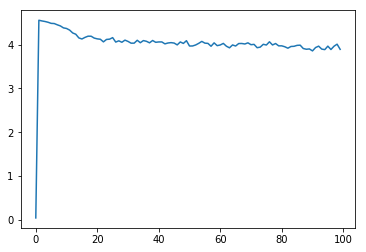

In [6]:
max_chars = 10 # max 10 chars for password

def sample(start_letter='a'):
    with torch.no_grad():  # no need to track history in sampling
        input = passwordToTensor(start_letter)
        hidden = model.initHidden()

        output_name = start_letter

        for i in range(max_chars):
            output, hidden = model(input[0], hidden)
            topv, topi = output.topk(1)
            topi = topi[0][0]
            if topi == len_letters - 1:
                break
            else:
                letter = letters[topi]
                output_name += letter
            input = passwordToTensor(letter)

        return output_name
#before train
random_start_char = random.choice(letters)
gen_password = sample(random_start_char)
print('Sampled Password: ', gen_password)

#train
#train(range(len(passwords)))
train(10000)

#after train
gen_password = sample(random_start_char)
print('Sampled Password: ', gen_password)